In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense,SimpleRNN, LSTM,Dropout,Convolution2D,MaxPooling2D
from keras.models import Sequential
from keras.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import glob
import os

In [2]:
NUM_CLASSES = 2
NUM_INPUTS = 10
SCALE_X = 1
SCALE_Y = 1

In [3]:
import random #random.shuffle() : shuffle the data of 1D
from sklearn.utils import shuffle #for 2D shuffle
import cv2
import matplotlib.pyplot as plt
import multiprocessing as mp
from tqdm import tqdm

class Dataset():
  def __init__(self,num_classes = NUM_CLASSES,num_input = NUM_INPUTS,scale_x = SCALE_X, scale_y = SCALE_Y,
               train_src="/content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/動画/20230302/dataset/train.csv",
               test_src="/content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/動画/20230302/dataset/test.csv"
               ):
    self.train_src = train_src
    self.test_src = test_src
    self.num_classes = num_classes
    self.num_input = num_input
    self.scale_x = scale_x
    self.scale_y = scale_y
    #num of cpu
    cpu_num = mp.cpu_count()
    print(f"{cpu_num} cpu is available")

    #return from self.function
    self.url_train, self.label_train, self.url_test, self.label_test,self.width, self.height = self.load_dataset()
    self.num_spatter_train = self.count_spatter(self.label_train)
    self.num_spatter_test = self.count_spatter(self.label_test)
    print(f"-- Number of Spatter data --\nTrain:{self.num_spatter_train}/{len(self.label_train)}\nTest:{self.num_spatter_test}/{len(self.label_test)}")

    #primitive img data
    """
    p = mp.Pool(cpu_num)
    self.img_train = np.zeros((len(self.url_train),len(self.url_train[1]),self.width,self.height))
    self.img_test = np.zeros((len(self.url_test),len(self.url_test[1]),self.width,self.height))
    count_train = 0
    count_test = 0
    for img in tqdm(p.imap_unordered(self.url2img_step, self.url_train), total=self.url_train.shape[0]):
      self.img_train[count_train] = img
      count_train += 1
    for img in tqdm(p.imap_unordered(self.url2img_step, self.img_test), total=self.url_test.shape[0]):
      self.img_test[count_train] = img
      count_test += 1
    p.close()
    """
    print("TRAIN PROCESSING ::: URL -> IMG")
    self.img_train_origin = self.url2img(self.url_train)
    print("TEST PROCESSING ::: URL -> IMG")
    self.img_test_origin = self.url2img(self.url_test)

    #process img data
    self.img_train,self.label_train,self.img_test,self.label_test = self.processImg()

  def load_dataset(self):
    """load dataset from csv file
    """
    train = pd.read_csv(filepath_or_buffer = self.train_src).values
    test = pd.read_csv(filepath_or_buffer =self.test_src).values
    #shuffle data
    train = shuffle(train,random_state=42)#random_state = integer ; fix randomness with shuffling
    test = shuffle(test,random_state=42)
    #split data into urls and labels
    url_train = train[:,1:]
    label_train =  train[:,0]
    url_test = test[:,1:]
    label_test = test[:,0]

    #show dataset
    #img data
    img=cv2.imread(train[200,1])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (width,height) = gray.shape
    gray = np.resize(gray,(int(width*self.scale_x),int(height*self.scale_y)))
    print(f"dataset image shape : {gray.shape}")
    #cv2.imshow("gray",gray)

    return url_train, label_train, url_test, label_test,width,height


  def count_spatter(self,data):
    """count spatter data
    Args :
      data : label dataset
    """
    count = 0
    for i in range(len(data)):
      if data[i] == 1:
        count += 1
    return count

  def url2img(self,data):
    """convert URL data to img data
    """
    image_data = np.zeros((len(data),len(data[1]),int(self.width*self.scale_x),int(self.height*self.scale_y)))
    print(f"input image size :: {(int(self.width*self.scale_x),int(self.height*self.scale_y))}")
    size = (int(self.width*self.scale_x),int(self.height*self.scale_y))
    for i in range(len(data)-1):
      if i%100 == 99:
          print(f"{round((i+1)*100/len(data),0)}%")
      #new to old
      for j,name in enumerate(data[i]):
        img=cv2.imread(name)
        #print(img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray  = cv2.resize(gray,size,interpolation = cv2.INTER_AREA)
        image_data[i][-(j+1)]=gray #last one is new
    print("100% completed")
    return image_data

  def url2img_step(self,data):
    """convert URL data to img data
    """
    image_data = np.zeros((len(data),len(data[1]),int(self.width*self.scale_x),int(self.height*self.scale_y)))
    print(f"input image size :: {(int(self.width*self.scale_x),int(self.height*self.scale_y))}")
    for j,name in enumerate(data):
      img=cv2.imread(name)
      #print(img)
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      gray = np.resize(gray,(int(self.width*self.scale_x),int(self.height*self.scale_y)))
      image_data[-(j+1)]=gray #old to new
    return image_data

  def processImg(self):
    ## split data into training data and test data
    image_train = self.img_train_origin.reshape(len(self.img_train_origin),self.num_input,int(self.width*self.scale_x),int(self.height*self.scale_y),1)
    image_test = self.img_test_origin.reshape(len(self.img_test_origin),self.num_input,int(self.width*self.scale_x),int(self.height*self.scale_y),1)

    #when calculating (dividing process) the type have to be float
    image_train = image_train.astype("float32")
    image_test = image_test.astype("float32")

    #when training, it is convenient if the values are normalized
    image_train= image_train/255
    image_test = image_test/255
    #standardization
    image_train = 2*image_train - np.ones(image_train.shape)
    image_test = 2*image_test - np.ones(image_test.shape)

    # converting data to float32, especially float32
    #image_train =np.asarray(image_train).astype(np.float32)
    labels_train = np.asarray(self.label_train).astype(np.int32)
    #image_test =np.asarray(image_test).astype(np.float32)
    labels_test = np.asarray(self.label_test).astype(np.int32)

    label_train_onehot = self.label2vec(labels_train)
    print(label_train_onehot.shape)
    label_test_onehot = self.label2vec(labels_test)
    print(label_test_onehot.shape)

    return image_train,label_train_onehot, image_test,label_test_onehot

  # convert label into array(2) [no-spatter, spatter]
  def label2vec(self,label):
    """convert labels to one-hot vector
    """
    lab = np.zeros((label.shape[0],self.num_classes))
    for i in range(label.shape[0]):
      if label[i] == 1: #spatter
        lab[i,1] = 1
      else: #no spatter
        lab[i,0] = 1
    return lab

In [4]:
dataset = Dataset(num_classes = 2,num_input = 10,scale_x = 1, scale_y = 1,
                  train_src=r"C:\Users\Furukawa\Documents\TechAssistant\dataset\csv\resNet\train.csv",
                  test_src=r"C:\Users\Furukawa\Documents\TechAssistant\dataset\csv\resNet\test.csv")
img_train_origin,img_test_origin = dataset.img_train_origin,dataset.img_test_origin
img_train,label_train, img_test,label_test = dataset.img_train,dataset.label_train,dataset.img_test,dataset.label_test

36 cpu is available
dataset image shape : (80, 80)
-- Number of Spatter data --
Train:2141/9095
Test:260/1001
TRAIN PROCESSING ::: URL -> IMG
input image size :: (80, 80)
1.0%
2.0%
3.0%
4.0%
5.0%
7.0%
8.0%
9.0%
10.0%
11.0%
12.0%
13.0%
14.0%
15.0%
16.0%
18.0%
19.0%
20.0%
21.0%
22.0%
23.0%
24.0%
25.0%
26.0%
27.0%
29.0%
30.0%
31.0%
32.0%
33.0%
34.0%
35.0%
36.0%
37.0%
38.0%
40.0%
41.0%
42.0%
43.0%
44.0%
45.0%
46.0%
47.0%
48.0%
49.0%
51.0%
52.0%
53.0%
54.0%
55.0%
56.0%
57.0%
58.0%
59.0%
60.0%
62.0%
63.0%
64.0%
65.0%
66.0%
67.0%
68.0%
69.0%
70.0%
71.0%
73.0%
74.0%
75.0%
76.0%
77.0%
78.0%
79.0%
80.0%
81.0%
82.0%
84.0%
85.0%
86.0%
87.0%
88.0%
89.0%
90.0%
91.0%
92.0%
93.0%
95.0%
96.0%
97.0%
98.0%
99.0%
100% completed
TEST PROCESSING ::: URL -> IMG
input image size :: (80, 80)
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%
100% completed
(9095, 2)
(1001, 2)


In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11710891886791488434
 xla_global_id: -1]

In [20]:
from re import L
import tensorflow as tf
from logging import Filter
#from keras.engine.sequential import model_serialization
#from tensorflow_datasets.core.dataset_builder import units
from tensorflow import keras
from keras import Input, Model
from keras.layers import TimeDistributed, Activation,BatchNormalization,SeparableConv2D,GRU,Conv2D,GlobalAveragePooling2D,GlobalMaxPooling2D,LayerNormalization
from keras import layers
from keras import backend as K
#from keras.layers.core import Reshape
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D,AveragePooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import LayerNormalization
from keras.layers import Bidirectional
from sklearn.metrics import classification_report
from keras.layers import LSTM
from keras.utils import plot_model

class ResNet():
  def __init__(self,img_train,label_train,img_test,label_test,
               img_train_origin,img_test_origin,
               num_filters,input_size,
               kernel_size=3,lr = 0.1,num_classes=2,num_epoch = 100, batch = 32,threshold = 0.5,step_epoch=20,warmup = 20,
               loss = "binary_crossentropy",classifier = "lstm",checkpoint = r'C:\Users\Furukawa\Documents\TechAssistant\ML_results\resnet\model',
               tpu=False,cosine_scheduler = True):
    self.img_train = img_train
    self.label_train = label_train
    self.img_test = img_test
    self.label_test = label_test
    self.img_train_origin = img_train_origin
    self.img_test_origin = img_test_origin
    self.kernel = (kernel_size,kernel_size)
    self.num_filters = num_filters
    self.input_size = input_size
    self.lr = lr
    self.warmup = warmup
    self.loss = loss
    self.classifier = classifier
    self.num_classes = num_classes
    self.step_epoch = step_epoch
    self.epochs = num_epoch

    self.feature_size =  [80**2,40**2,20**2,10**2,5**2,3**2,2**2,1]

    #model construction
    if tpu:
      print(" -- MODE :: TPU -- ")
      strategy = tf.distribute.TPUStrategy(tpu)
      print("Number of replicas: {strategy.num_replicas_in_sync}")
      with strategy.scope():
          self.model = self.build_model()
    else:
      print(" -- MODE :: CPU -- ")
      self.model = self.build_model()

    #Model summary
    self.model.summary()
    plot_model(self.model,show_shapes = True,show_layer_names = False)

    #call back
    if cosine_scheduler:
      callback_scheduler = tf.keras.callbacks.LearningRateScheduler(self.cosine_scheduler)
    if not cosine_scheduler:
      callback_scheduler = tf.keras.callbacks.LearningRateScheduler(self.scheduler)
    save_file = os.path.join(checkpoint,f'resnet_2_4_8_.hdf5')
    Modelcheckpoint = keras.callbacks.ModelCheckpoint(filepath = save_file, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    #model training
    self.history = self.model.fit(img_train, label_train, epochs=num_epoch,validation_data = (img_test,label_test), batch_size = batch,callbacks =[callback_scheduler])#, Modelcheckpoint])#callback_scheduler,
    #plot learning status
    self.plotData()

    #evaluation
    self.threshold = threshold
    self.metricsPlot(test=False)
    self.metricsPlot(test=True)

  def res_conv_block(self,input,num_filter,pooling=False):
    """residual convolutional layer
    """
    residual = input
    conv2d_1 = Conv2D(num_filter,self.kernel,padding = "same")
    outputs = TimeDistributed(conv2d_1)(input)
    #conv2d_2 = Conv2D(num_filter,self.kernel,padding = "same")
    #outputs = TimeDistributed(conv2d_2)(outputs)

    if pooling:#whether Maxpooling layer is or not
      pool_0 = MaxPooling2D((2,2),strides = 2,padding='same')#32*32
      outputs = TimeDistributed(pool_0)(outputs)
      conv_res = Conv2D(num_filter,1,strides = 2)
      residual = TimeDistributed(conv_res)(residual)
    else:
      conv_res = Conv2D(num_filter,1)
      residual = TimeDistributed(conv_res)(residual)

    outputs = layers.add([outputs,residual])
    filter = Activation("relu")
    outputs = TimeDistributed(filter)(outputs)
    return outputs

  def build_model(self):
    """build model structure
    classifier : type of classifier ex) 'lstm','dense','bilstm'
    num_filters(list) : num of filters ex) [4,8,16,32] ---
    """
    #conv part
    input = Input(shape=self.input_size)
    conv = self.res_conv_block(input,self.num_filters[0],pooling=True)
    for i in range(1,len(self.num_filters)-1):
      conv = self.res_conv_block(conv,self.num_filters[i],pooling=True)
    conv2d = Conv2D(self.num_filters[-1],self.kernel,padding = "same")
    outputs = TimeDistributed(conv2d)(conv)
    filter = Activation('relu')
    outputs = TimeDistributed(filter)(outputs)
    pool = MaxPooling2D((2,2),strides = 2,padding='same')#32*32
    outputs = TimeDistributed(pool)(outputs)

    #classifier part
    if self.classifier.lower() == "lstm":
      x = TimeDistributed(Flatten())(outputs)
      x = LSTM(100,recurrent_dropout=0.25)(x)
      #x = LSTM(self.num_filters[-1]*self.feature_size[len(self.num_filters)],recurrent_dropout=0.25,return_sequences=True)(x)
      #x = LSTM(self.num_filters[-1]*self.feature_size[len(self.num_filters)],recurrent_dropout=0.25)(x)
      x = Dense(100)(x)
      x=Activation("relu")(x)
      x = Dropout(0.1)(x)
      #x = Dense(self.num_filters[-1]*self.feature_size[len(self.num_filters)])(x)
    elif self.classifier.lower() == 'dense':
      outputs = Flatten()(outputs)
      x = Dense(self.num_filters[-1]*self.feature_size[len(self.num_filters)]*10)(outputs)
      x = Activation('relu')(x)
      x =Dropout(0.1)(x)

      x = Dense(self.num_filters[-1]*self.feature_size[len(self.num_filters)]//8)(x)
      x = Activation('relu')(x)
      x = Dropout(0.1)(x)

      x = Dense(self.num_filters[-1]*self.feature_size[len(self.num_filters)]//8)(x)
      x = Activation('relu')(x)
      x = Dropout(0.1)(x)

      x = Dense(self.num_filters[-1]*self.feature_size[len(self.num_filters)]//8)(x)
      x = Activation('relu')(x)
      x = Dropout(0.1)(x)
    elif self.classifier.lower() == 'bilstm':
      x = TimeDistributed(Flatten())(outputs)
      x = Bidirectional(LSTM(self.num_filters[-1]*self.feature_size[len(self.num_filters)]//8))(x)
      x = Dropout(0.1)(x)
      #x = Dense(self.num_filters[-1]*self.feature_size[len(self.num_filters)])(x)

    #output layer
    output = Dense(self.num_classes,activation='softmax')(x)

    #define model
    model = Model(inputs = input,outputs = output)

    # Compiling
    #opt = keras.optimizers.RMSprop(learning_rate = self.lr)
    opt = keras.optimizers.Adam(learning_rate = self.lr)
    model.compile(optimizer = opt,
                  loss=self.loss,
                  metrics = ['accuracy'])
    return model

  def scheduler(self,epoch,lr):
    if (epoch+1)%self.step_epoch == 0:
      lr = lr*0.1
    return lr

  def cosine_scheduler(self, epoch,lr):
      """
      Arguments
      ---------
      epoch : int
          現在のエポック数．
      """
      progress = (epoch -self.warmup) / (self.epochs - self.warmup)
      progress = np.clip(progress, 0.0, 1.0)
      lr = self.lr * 0.5 * (1. + np.cos(np.pi * progress))

      if self.warmup:
          lr = lr * min(1., (epoch+1) / self.warmup)

      return lr

  def plotData(self):
    #plot vonverging process :
    plt.subplots(figsize = (10,5))
    plt.plot(self.history.history["loss"],label = "Loss")
    plt.plot(self.history.history["val_loss"], label = "val_loss")
    plt.title("Converging state")
    plt.xlabel("epoch")
    plt.ylabel("binary_crossentropy")
    plt.legend()
    plt.show()

    # Accuracy
    plt.subplots(figsize = (10,5))
    plt.plot(self.history.history['accuracy'], label = "accuracy")
    plt.plot(self.history.history['val_accuracy'],label = 'val_accuracy')
    plt.title('model accuracy')
    plt.ylabel('accuracy')  # Y軸ラベル
    plt.xlabel('epoch')  # X軸ラベル
    plt.grid()
    plt.legend(loc='best')
    plt.show()


  #split label data into a scaler
  def vec2scaler(self,data):
    spatter_label = []
    non_label = []
    for i in range(data.shape[0]):
      if data[i][0] == 1: #non spatter
        non_label.append(1)
        spatter_label.append(None)
      else:#spatter
        non_label.append(None)
        spatter_label.append(1)
    return spatter_label,non_label

  def save_spatter_judge_img(self,predict_data,label_data):
    Spatter = []
    TP = 0
    FN = 0

    save_root_dir = r"C:\Users\Furukawa\Documents\TechAssistant\ML_results\resnet\spatterJudge"
    saveDir = os.path.join(save_root_dir,self.classifier)
    if not os.path.exists(saveDir):
      os.makedirs(saveDir)
    spatter_tp_dir = os.path.join(save_root_dir,"True_positive")
    if not os.path.exists(spatter_tp_dir):
      os.makedirs(spatter_tp_dir)
    spatter_fn_dir = os.path.join(save_root_dir,"False_negative")
    if not os.path.exists(spatter_fn_dir):
      os.makedirs(spatter_fn_dir)
    
    #decide spatter or not according to threshold
    for i in range(predict_data.shape[0]):
      if predict_data[i,1] >= self.threshold:
        Spatter.append(1)
      else :
        Spatter.append(0)

    spatter_label,non_label = self.vec2scaler(label_data)

    #spatter true positive indexes
    spatter_TP = []
    #spater false negative
    spatter_FN = []
    #number of inputs
    numInputs = self.img_test_origin.shape[1]
    width = self.img_test_origin.shape[3]
    height = self.img_test_origin.shape[2]
    for i in range(len(spatter_label)):

      if spatter_label[i] == 1:
        if Spatter[i] == 1:#TP
          TP +=1
          spatter_TP.append(i)

          saveImg = np.zeros((height,(numInputs*width)))
          filename=os.path.join(spatter_tp_dir,f"{i:03d}.jpg")
          for j in range(numInputs):
            saveImg[:,j*width:(j+1)*width] = self.img_test_origin[i][j]
          cv2.imwrite(filename,saveImg)
        elif Spatter[i] == 0: #FN
          FN +=1
          spatter_FN.append(i)
          saveImg = np.zeros((height,(numInputs*width)))
          filename=os.path.join(spatter_fn_dir,f"{i:03d}.jpg")
          for j in range(numInputs):
            saveImg[:,j*width:(j+1)*width] = self.img_test_origin[i][j]
          cv2.imwrite(filename,saveImg)
          
  def metrics_change(self,predict_data,label_data):
    Spatter = []

    #decide spatter or not according to threshold
    for i in range(predict_data.shape[0]):
      if predict_data[i,1] >= self.threshold:
        Spatter.append(1)
      else :
        Spatter.append(0)

    spatter_label,non_label = self.vec2scaler(label_data)

    #evaluation parameter
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i in range(len(spatter_label)):

      if spatter_label[i] == 1:
        if Spatter[i] == 1:#TP
          TP +=1
        elif Spatter[i] == 0: #FN
          FN +=1
      elif non_label[i] == 1:
        if Spatter[i] == 1:#FP
          FP += 1
        elif Spatter[i] == 1:#TN
          TN += 1

    print("(TP,FN,FP,TN)",(TP,FN,FP,TN))

    all = len(spatter_label)
    print(all)
    accuracy = (TP+TN)/all
    if TP+FP > 0:
      precision = TP/(TP+FP)
    else:
      precision = None
    recall = TP/(TP+FN)
    if precision == 0 or precision == None or recall == 0:
      f_value = None
    else:
      f_value = 2*precision*recall/(precision+recall)

    return accuracy, precision, recall,f_value

  def frange(self,start, end , step):
    if step == 0:
        raise ValueError('step must not be zero')

    start = float(start)
    end = float(end)
    step = float(step)

    # range関数と同様な振る舞いにする
    if abs(step) > abs(start - end):
        return [start]
    if step > 0 and end - start < 0:
        return []
    elif step < 0 and end - start > 0:
        return []

    exp = len(str(step).split('.')[1])  # 丸める際に使用する桁数
    result = [start]
    val = start
    if step > 0:
        while (val := round(val + step, exp)) < end:
            result.append(val)
    else:
        while (val := round(val + step, exp)) > end:
            result.append(val)
    return result

  def metricsPlot(self,test=True):
    Accuracy = []
    Precision = []
    Recall = []
    F_value = []
    Threshold = []

    if test:
      print("TEST DATA EVALUATION")
      predict_data =self.model.predict(self.img_test)
    else:
      print("TRAIN DATA EVALUATION")
      predict_data = self.model.predict(self.img_train)
    for threshold in self.frange(0.0,1.0,0.05):
      if test:
        accuracy,precision,recall,f_value = self.metrics_change(predict_data,self.label_test)
      else:
        accuracy,precision,recall,f_value = self.metrics_change(predict_data,self.label_train)
      Threshold.append(threshold)
      Accuracy.append(accuracy)
      Precision.append(precision)
      Recall.append(recall)
      F_value.append(f_value)
    
    #save spatter judge img
    if test:
      threshold = 0.5
      self.save_spatter_judge_img(predict_data,self.label_test)

    plt.subplots(figsize=(7,7))
    plt.plot(Threshold,Accuracy,color ='b',label = 'Accuracy')
    plt.plot(Threshold,Precision,color ='y',label = 'Precision')
    plt.plot(Threshold,Recall,color ='g',label = 'Recall')
    plt.plot(Threshold,F_value,linewidth = 3,color ='r',label = 'F value')
    plt.legend()
    plt.show()


#Train

In [21]:
print(img_test_origin.shape)

(1001, 10, 80, 80)


 -- MODE :: CPU -- 
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 10, 80, 80, 1)]      0         []                            
                                                                                                  
 time_distributed_28 (TimeD  (None, 10, 80, 80, 2)        20        ['input_5[0][0]']             
 istributed)                                                                                      
                                                                                                  
 time_distributed_29 (TimeD  (None, 10, 40, 40, 2)        0         ['time_distributed_28[0][0]'] 
 istributed)                                                                                      
                                                                        

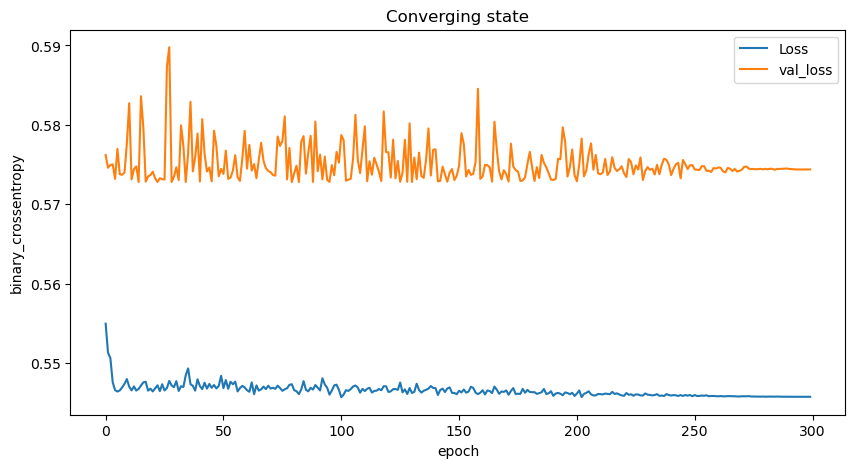

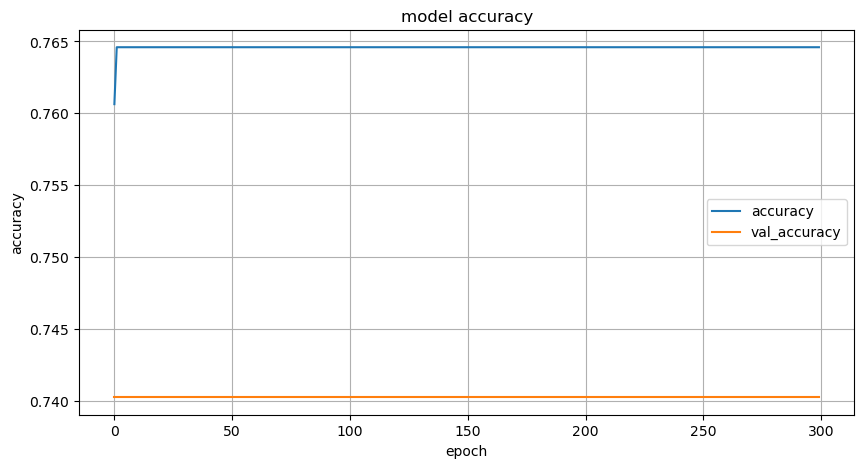

TRAIN DATA EVALUATION
285/285 [==============================] - 14s 48ms/step
(TP,FN,FP,TN) (0, 2141, 0, 0)
9095
(TP,FN,FP,TN) (0, 2141, 0, 0)
9095
(TP,FN,FP,TN) (0, 2141, 0, 0)
9095
(TP,FN,FP,TN) (0, 2141, 0, 0)
9095
(TP,FN,FP,TN) (0, 2141, 0, 0)
9095
(TP,FN,FP,TN) (0, 2141, 0, 0)
9095
(TP,FN,FP,TN) (0, 2141, 0, 0)
9095
(TP,FN,FP,TN) (0, 2141, 0, 0)
9095
(TP,FN,FP,TN) (0, 2141, 0, 0)
9095
(TP,FN,FP,TN) (0, 2141, 0, 0)
9095
(TP,FN,FP,TN) (0, 2141, 0, 0)
9095
(TP,FN,FP,TN) (0, 2141, 0, 0)
9095
(TP,FN,FP,TN) (0, 2141, 0, 0)
9095
(TP,FN,FP,TN) (0, 2141, 0, 0)
9095
(TP,FN,FP,TN) (0, 2141, 0, 0)
9095
(TP,FN,FP,TN) (0, 2141, 0, 0)
9095
(TP,FN,FP,TN) (0, 2141, 0, 0)
9095
(TP,FN,FP,TN) (0, 2141, 0, 0)
9095
(TP,FN,FP,TN) (0, 2141, 0, 0)
9095
(TP,FN,FP,TN) (0, 2141, 0, 0)
9095


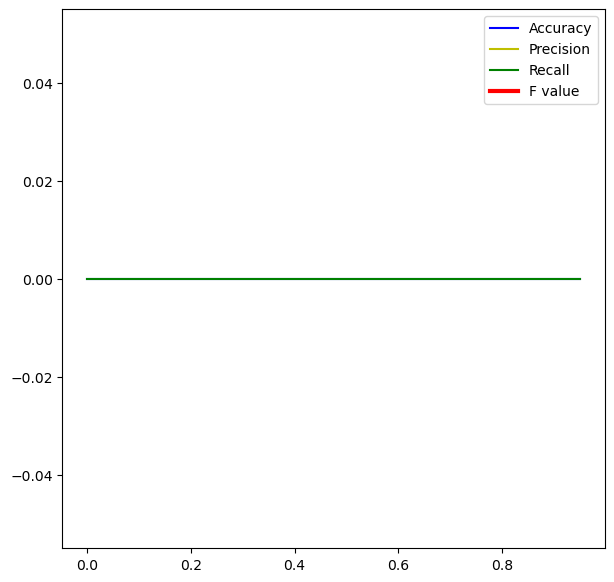

TEST DATA EVALUATION
32/32 [==============================] - 2s 48ms/step
(TP,FN,FP,TN) (0, 260, 0, 0)
1001
(TP,FN,FP,TN) (0, 260, 0, 0)
1001
(TP,FN,FP,TN) (0, 260, 0, 0)
1001
(TP,FN,FP,TN) (0, 260, 0, 0)
1001
(TP,FN,FP,TN) (0, 260, 0, 0)
1001
(TP,FN,FP,TN) (0, 260, 0, 0)
1001
(TP,FN,FP,TN) (0, 260, 0, 0)
1001
(TP,FN,FP,TN) (0, 260, 0, 0)
1001
(TP,FN,FP,TN) (0, 260, 0, 0)
1001
(TP,FN,FP,TN) (0, 260, 0, 0)
1001
(TP,FN,FP,TN) (0, 260, 0, 0)
1001
(TP,FN,FP,TN) (0, 260, 0, 0)
1001
(TP,FN,FP,TN) (0, 260, 0, 0)
1001
(TP,FN,FP,TN) (0, 260, 0, 0)
1001
(TP,FN,FP,TN) (0, 260, 0, 0)
1001
(TP,FN,FP,TN) (0, 260, 0, 0)
1001
(TP,FN,FP,TN) (0, 260, 0, 0)
1001
(TP,FN,FP,TN) (0, 260, 0, 0)
1001
(TP,FN,FP,TN) (0, 260, 0, 0)
1001
(TP,FN,FP,TN) (0, 260, 0, 0)
1001


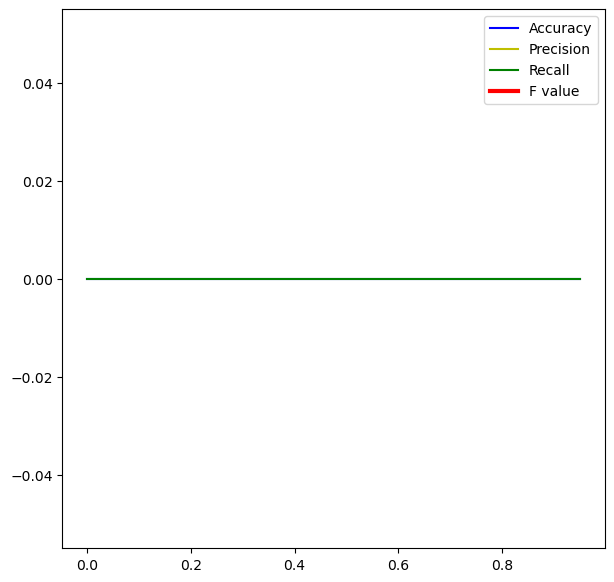

In [22]:
EPOCHS = 300
BATCH = 64
HEIGHT = int(SCALE_X * dataset.width)
WIDTH = int(SCALE_Y * dataset.height)
THRESHOLD = 0.5
KERNEL_SIZE = 3
LEARNING_RATE = 0.1
STEP_EPOCH = 60
WARMUP = 10
FILTERS_CONV = [2,4,8,16]
LOSS = "binary_crossentropy"
CLASSIFIER = "lstm"
CHECKPOINT = r'C:\Users\Furukawa\Documents\TechAssistant\ML_results\resnet\model\spatter_resnet_2_4_8_lstm3000.keras'

resnet = ResNet(img_train=img_train,label_train=label_train,img_test=img_test,label_test=label_test,
                img_train_origin=img_train_origin,img_test_origin=img_test_origin,
               num_filters=FILTERS_CONV,input_size=(NUM_INPUTS,WIDTH,HEIGHT,1),
               kernel_size=KERNEL_SIZE,lr = LEARNING_RATE,num_classes=NUM_CLASSES,num_epoch = EPOCHS, batch = BATCH,threshold = THRESHOLD,step_epoch = STEP_EPOCH,warmup = WARMUP,
               loss = LOSS,classifier = CLASSIFIER,checkpoint = CHECKPOINT,
               tpu=False,cosine_scheduler=True)
model = resnet.model

#visualize model structure

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes = True,show_layer_names = False)

#make heatmap

In [10]:
last_conv_layer_name = 'time_distributed_9'
classifier_layer_names = ['time_distributed_10','time_distributed_11','bidirectional','dropout','dense']#'time_distributed_47'
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs,last_conv_layer.output)

adapt classifer for last conv layer

In [11]:
classifier_input = keras.Input(shape = last_conv_layer.output.shape[1:])
x = classifier_input
#make model
for layer_name in classifier_layer_names:
  x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input,x)

get gradients of highly predicted class

In [12]:
import tensorflow as tf

img = img_test[3]
print(label_test[3])
img = np.expand_dims(img,axis=0)
with tf.GradientTape() as tape:

  #calculate last conv layer's activation and enroll for GradientTape
  last_conv_layer_output = last_conv_layer_model(img) #(1,9,7.7,32)
  print(last_conv_layer_output.shape)
  tape.watch(last_conv_layer_output)

  #get a channel of most highly predicted class
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  top_class_channel = preds[:,top_pred_index] #tensor shape=(1,)

#last class gradient based on last conv layer as input
grads = tape.gradient(top_class_channel,last_conv_layer_output) #(1,9,7,7,32)

[1. 0.]
(1, 10, 20, 20, 8)


weighting each channel

In [13]:
Heatmap = np.zeros((last_conv_layer_output.shape[1],last_conv_layer_output.shape[2],last_conv_layer_output.shape[3]))
for i in range(grads.shape[1]):
  grads_tmp = grads[0,i,:,:,:]
  #averaging for each filter
  pooled_grads = tf.reduce_mean(grads_tmp,axis=(0,1)).numpy()
  print(pooled_grads.shape)#(1,9)
  last_conv_layer_output_tmp = last_conv_layer_output.numpy()[0][i]
  print(last_conv_layer_output_tmp.shape)#

  #multiply weights by each filter
  for j in range(pooled_grads.shape[-1]):
    last_conv_layer_output_tmp[:,:,j] *= pooled_grads[j]

  #average for each filter
  heatmap = np.mean(last_conv_layer_output_tmp,axis = -1) #all
  print(heatmap.shape)
  Heatmap[i,:,:] = heatmap

(8,)
(20, 20, 8)
(20, 20)
(8,)
(20, 20, 8)
(20, 20)
(8,)
(20, 20, 8)
(20, 20)
(8,)
(20, 20, 8)
(20, 20)
(8,)
(20, 20, 8)
(20, 20)
(8,)
(20, 20, 8)
(20, 20)
(8,)
(20, 20, 8)
(20, 20)
(8,)
(20, 20, 8)
(20, 20)
(8,)
(20, 20, 8)
(20, 20)
(8,)
(20, 20, 8)
(20, 20)


normalization of heatmap for 0~1

C:\Users\Furukawa\AppData\Local\Temp\ipykernel_21224\3267830185.py:4: RuntimeWarning: invalid value encountered in divide
  Heatmap[i,:,:] = Heatmap[i,:,:]/np.max(Heatmap[i,:,:])
C:\Users\Furukawa\AppData\Local\Temp\ipykernel_21224\3267830185.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


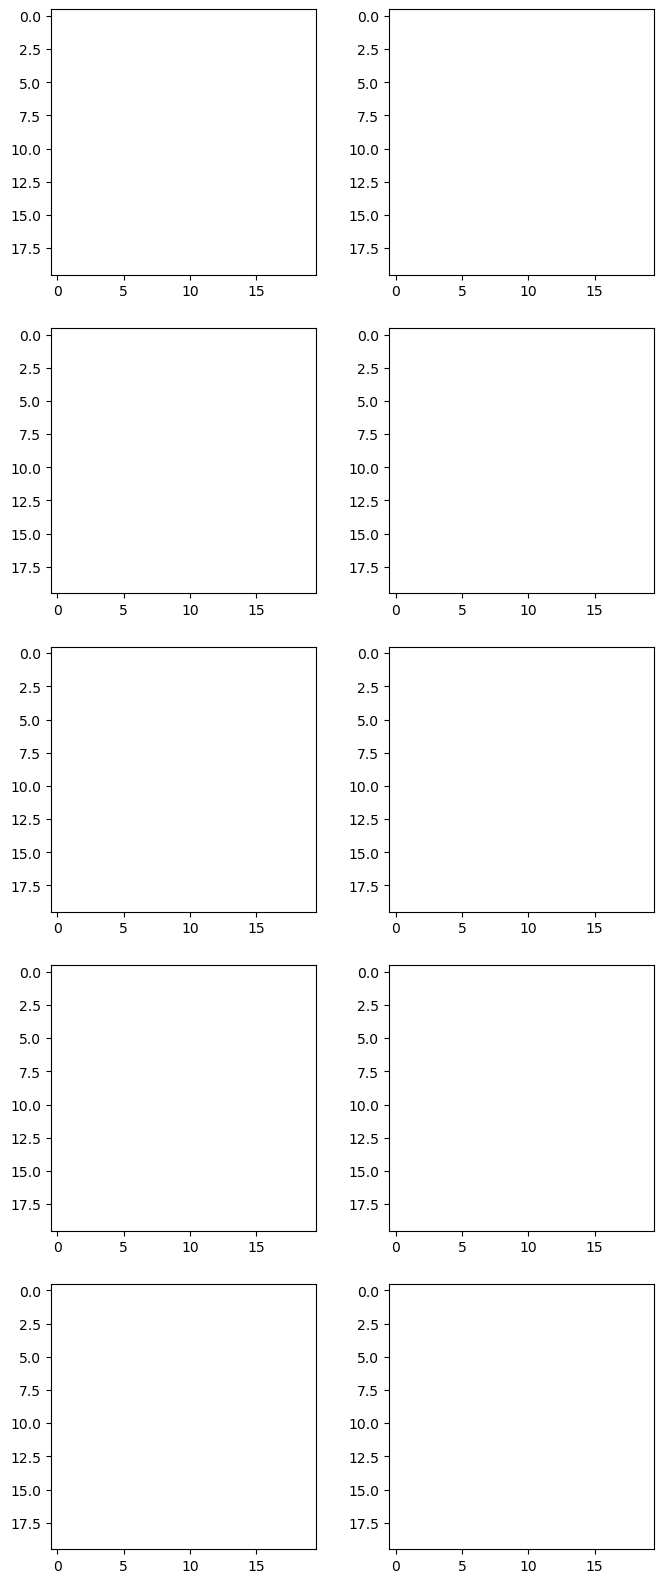

In [14]:
fig,ax = plt.subplots(5,2,figsize=(8,20))
for i in range(10):
  Heatmap[i,:,:] = np.maximum(Heatmap[i,:,:],0)
  Heatmap[i,:,:] = Heatmap[i,:,:]/np.max(Heatmap[i,:,:])
  #plt.matshow(Heatmap[i,:,:])
  ax[(i+1)%5,i//5].imshow(Heatmap[i,:,:])
fig.show()

superimpose heatmap to original image

label :  [0. 1.]


C:\Users\Furukawa\AppData\Local\Temp\ipykernel_21224\4286454199.py:9: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255*heatmap)
C:\Users\Furukawa\AppData\Local\Temp\ipykernel_21224\4286454199.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')
C:\Users\Furukawa\AppData\Local\Temp\ipykernel_21224\4286454199.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


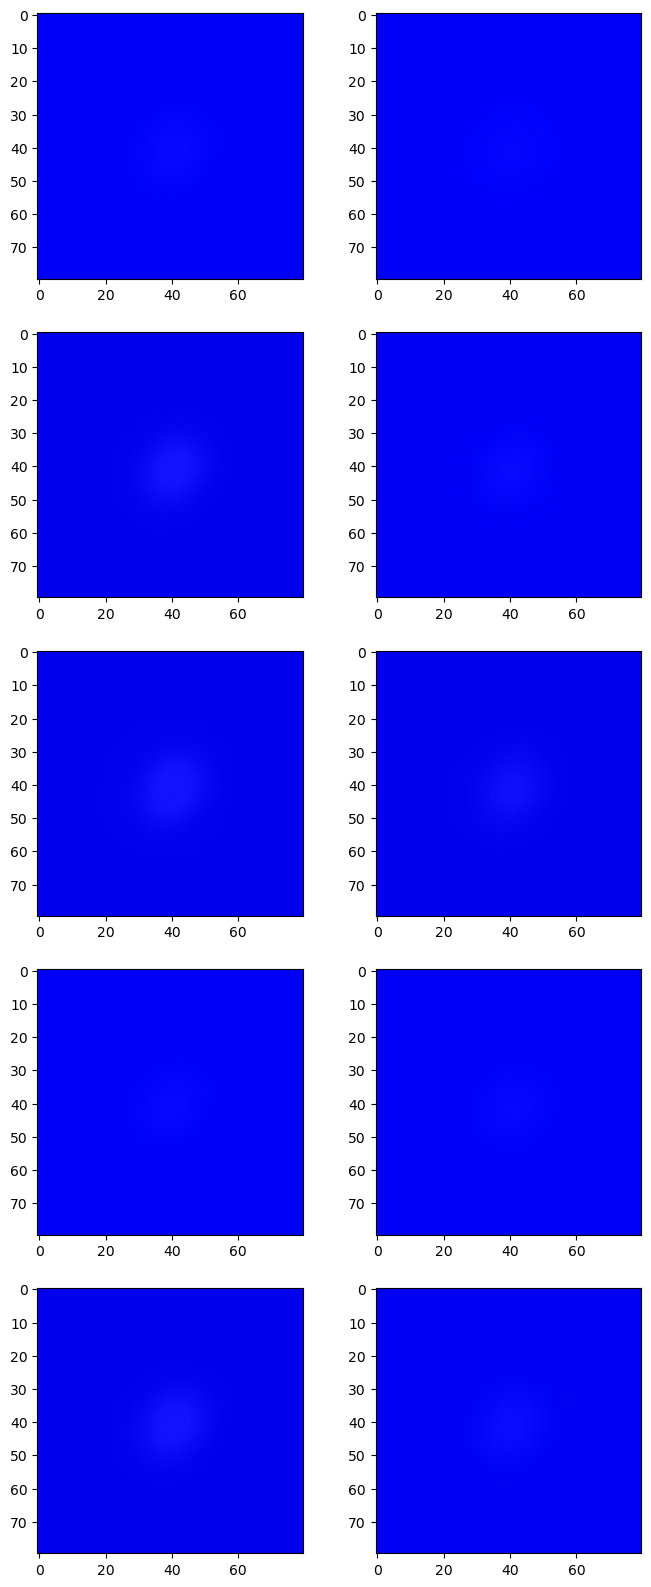

In [15]:
import matplotlib.cm as cm
print("label : ",label_test[4])
fig,ax = plt.subplots(5,2,figsize=(8,20))
for i in range(10):
  img = img_test[3][i]
  img = keras.utils.img_to_array(img)

  heatmap = Heatmap[i,:,:]
  heatmap = np.uint8(255*heatmap)
  #coloring heatmap
  jet = cm.get_cmap('jet')
  jet_colors = jet(np.arange(256))[:,:3]
  jet_heatmap = jet_colors[heatmap]

  #make img with heatmap
  jet_heatmap = keras.utils.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1],img.shape[0])) #order is different betweendimage and array
  jet_heatmap = keras.utils.img_to_array(jet_heatmap)

  #transparency rate = 40%
  superimposed_img = jet_heatmap*0.1+img
  superimposed_img = keras.utils.array_to_img(superimposed_img)
  #plt.figure(figsize=(30,3))
  #plt.subplot(1,10,i+1)
  #plt.imshow(superimposed_img)
  ax[(i+1)%5,i//5].imshow(superimposed_img)
fig.show()

#original img

C:\Users\Furukawa\AppData\Local\Temp\ipykernel_21224\3802771773.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


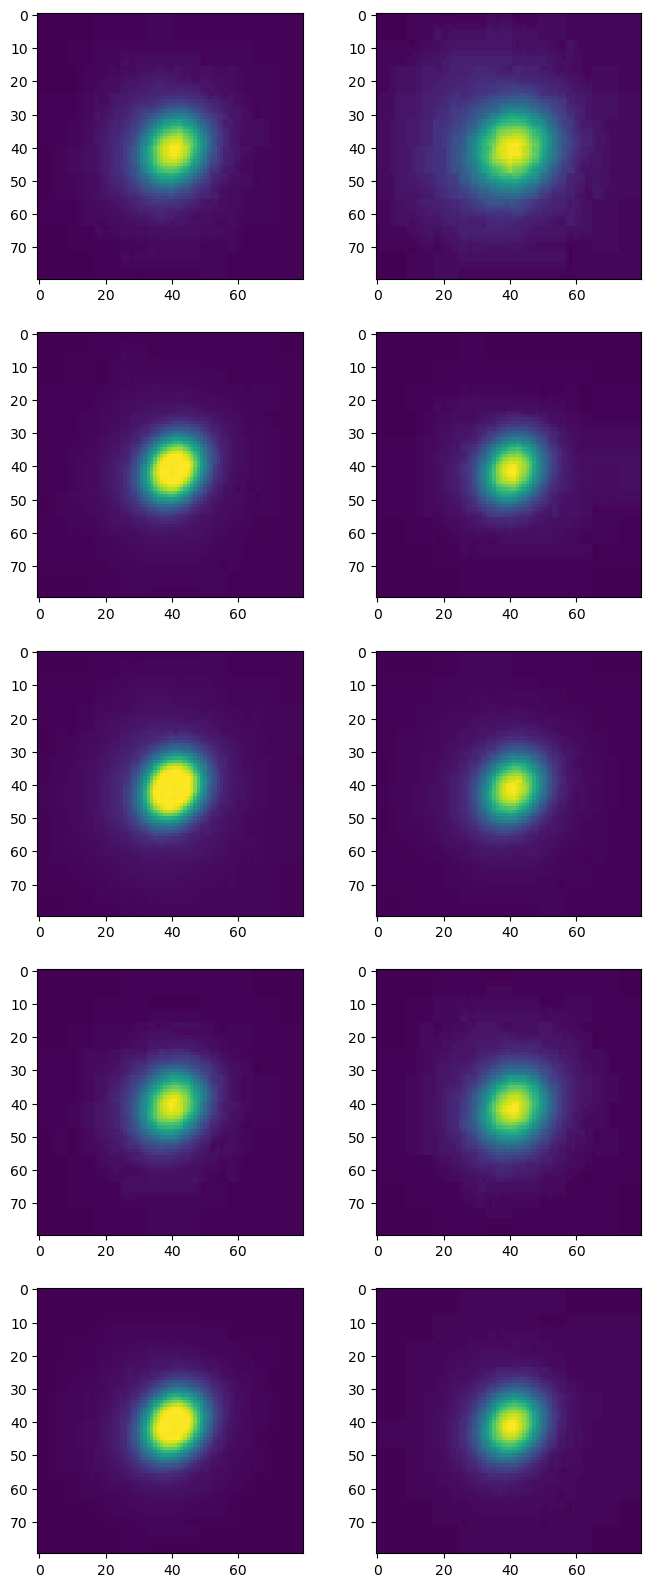

In [16]:
fig,ax = plt.subplots(5,2,figsize=(8,20))
for i in range(10):
  img = img_test[3][i]
  img = keras.utils.img_to_array(img)

  #plt.figure(figsize=(30,3))
  #plt.subplot(1,10,i+1)
  #plt.imshow(img)
  ax[(i+1)%5,i//5].imshow(img)
fig.show()